In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Non-parametric Bayesian Network"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

##  Non-parametric Bayesian Network

Non-parametric Bayesian Network applied on preselected feautre space from HCMC df_predictorsset, target variabels to predict are the relative commercial content losses [fraction of content loss and total content value ] of shophouses and their business reduction [% reduction in a month]

BN package: https://github.com/mike-mendoza/py_banshee

In [111]:
import sys, os
import logging
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.bn_plot import bn_visualize
from py_banshee.copula_test import cvm_statistic
from py_banshee.d_cal import gaussian_distance
from py_banshee.prediction import inference


sys.path.insert(0, "../")
import utils.settings as s
import utils.figures as f
import utils.evaluation_metrics as em


s.init()
seed = s.seed
pd.set_option('display.max_columns', None)
#plt.figure(figsize=(20, 10))

import warnings
warnings.filterwarnings('ignore')

target = "Target_relative_contentloss_euro"

## save models and their evaluation in following folders:
Path(f"../../model_results/bayesian_network/contentloss").mkdir(parents=True, exist_ok=True)


In [112]:
infile_name = "final_predictors_Target_relative_contentloss_euro"
df_hcmc = pd.read_excel(f"../model_results/selected_features/degree_of_loss/{infile_name}.xlsx")

## drop zero-losses due that they captured by chance of loss 
df_hcmc = df_hcmc.loc[df_hcmc[target] > 0.0, :]

print(df_hcmc.shape)
print(df_hcmc.tail(2))


(123, 14)
     Target_relative_contentloss_euro  shp_avgmonthly_sale_euro  bage   
299                          3.119191                     736.5  11.0  \
304                         10.875088                     276.2   3.0   

     flowvelocity  precautionary_measures_lowcost  water_depth_cm   
299           0.3                            0.25              30  \
304           0.5                            0.25              40   

     flood_experience  inundation_duration_h  resilience  emergency_measures   
299               151                    3.0         3.0            0.500000  \
304                76                    3.0         4.0            0.166667   

     precautionary_measures_expensive  b_area  shp_employees  contaminations  
299                          1.000000    48.0              3               0  
304                          0.333333    80.0              2               1  


In [128]:
# ## find predictor with highest unconditional correlation to target
# # f.plot_spearman_rank(df_hcmc)
# plt.figure(figsize=(15,15))
# heatmap = sns.heatmap(df_hcmc.corr(method="spearman"), 
#                       vmin=-1, vmax=1, 
#                       annot=True, fmt=".3f", 
#                       cmap="RdBu")

# # fv most corr ~ target

--> flowvelo correlates strongest with rcloss

In [139]:

# Set random seed to obtain the same inference results every run, for 
# research purposes (used by sampling in function inference from prediction.py)
np.random.seed(seed)

# Define name of output figure with BN; used by bn_visualize
fig_name = f'bn_{target}'

# Define the variable names
names_list = [
    'Target_relative_contentloss_euro', 'flowvelocity', 
    'water_depth_cm', 'b_area'
    #'shp_avgmonthly_sale_euro' #, 'water_depth_cm',
    ]
print(df_hcmc.columns)


# # Select the columns to use in the NPBN
df_hcmc_bn = df_hcmc[names_list]

names = {k: i for i, k in enumerate(names_list)}

print("Using following features:", names)

Index(['Target_relative_contentloss_euro', 'shp_avgmonthly_sale_euro', 'bage',
       'flowvelocity', 'precautionary_measures_lowcost', 'water_depth_cm',
       'flood_experience', 'inundation_duration_h', 'resilience',
       'emergency_measures', 'precautionary_measures_expensive', 'b_area',
       'shp_employees', 'contaminations'],
      dtype='object')
Using following features: {'Target_relative_contentloss_euro': 0, 'flowvelocity': 1, 'water_depth_cm': 2, 'b_area': 3}


In [143]:
# Extract number of nodes from df_hcmc
#N = 2 #11  # 3
N = df_hcmc_bn.shape[1]  # number of nodes == number of features + target
print(N)

# Defining the structure of the BN
parent_cell = [None]*N

### --- Schema example --- ###
# parent_cell[0] = []           # climate (no parents)
# parent_cell[1] = [2]          # arts (parent node: recreation)
# parent_cell[4] = [1, 2, 3, 0] # target=safety (parents: all other variables)

### --- Schema kid_cell = parent_cells --- ###
parent_cell[0] = [1, 2, 3] #,4,5,6,7,8,9,10]                                                 #   target (parents: all other features)
parent_cell[1] = [] #4
parent_cell[2] = [1]
parent_cell[3] = []
# parent_cell[4] = []


## check conditional spearman correlations of features: eg. b_area (evtl as standalone feature)

## small buildage/area -> less capital, if owner: building age -> b area -> capital, if rent : capital-> building
## test change one arc --> eval model
## hint: start small BN with two var with most correlated feature (2 vars) --> 
## get highest coorelation values
## 3. hydro vars (check conditional correlation given the registed captial)

## if new var doesnt add anything to cond corr (change arc or rm var)

## stop until no imporvement ~ 5-6 nodes for target


parent_cell

4


[[1, 2, 3], [], [1], []]

<Figure size 500x500 with 0 Axes>

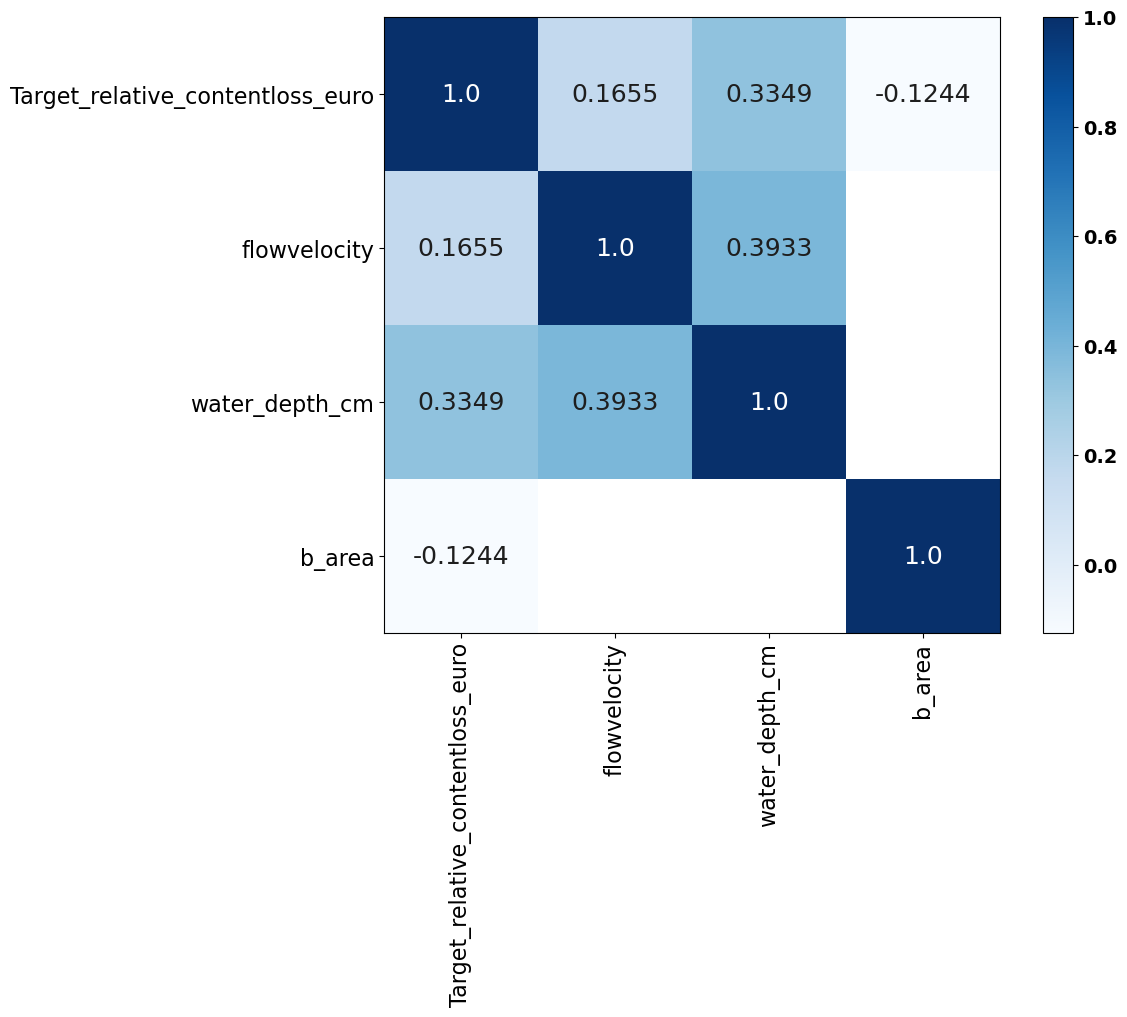

In [144]:
#-----------------------------------------------------------------------------
# Function 1 - bn_rankcorr - Conditional rank correlation matrix
#-----------------------------------------------------------------------------

plt.figure(figsize=(5,5))
R = bn_rankcorr(parent_cell,        # structure of the BN
                df_hcmc_bn,   # matrix of df_hcmc
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = True)           # create a plot (False = don't create plot)

# The plot shows that target has the strongest correlation with water_barriers_impl,
# then the conditional correlation with flowveloctity (but maybe only due to strong correlation with water_depth and inundation_duration ). The conditional 
# correlations with with xx and xxx are weaker. Between other 
# variables, there is strong dependency between shp_registered_capital and shp_avg_monhtly_sale.

# precaution -0.0456 ** (no matter if pre-> wd or wd -> prec)

## Evaluation

In [145]:
condition=[1, 2, 3] #, 4] #conditionalized variables, all except for target (predict)

num_folds = 10
trainset_size = int(len(df_hcmc_bn)/num_folds  // 1)

df_hcmc_bn_shuffle = df_hcmc_bn.sample(frac=1).reset_index(drop=True)  # reshuffle samples so that not all zero loss are in one fold
bn_scores = {a : [] for a in ["MAE", "MBE", "RMSE", "SMAPE"]}
residuals = pd.DataFrame()

for i in range(num_folds):
    
    # ## split Fold into train and test
    # train_nth_fold = df_hcmc_bn_shuffle[ ~df_hcmc_bn_shuffle.index.isin(tt.index)]
    test_nth_fold = df_hcmc_bn_shuffle[i*trainset_size:][:trainset_size]
    # print("Using following test samples to predict on", test_nth_fold.shape[0])

    # predict data for conditionalization for one fold
    values = test_nth_fold.iloc[:,condition].to_numpy() 

    # BN train on fold
    F_test_nth_fold = inference(condition,        # nodes that will be conditionalized
                values,           # information used to conditionalize the nodes of the NPBN
                R,                # the rank correlation matrix 
                test_nth_fold,        # DataFrame with df_hcmc
                #Output='mean')    # type of output data
                Output='median')    # type of output data
 
    ## predict target
    y_pred = F_test_nth_fold.squeeze()

    # Fill out the column(s) which are predicted
    y_true = test_nth_fold.iloc[:,0].to_numpy()

    ## store for plotting obs ~ pred
    residuals_per_fold = pd.concat([pd.Series(y_true), pd.Series(y_pred)], axis=1)
    residuals = pd.concat([residuals, residuals_per_fold], axis=0)

    # evaluation metrics
    MAE = em.mean_absolute_error(y_pred, y_true)
    MBE = em.mean_bias_error(y_pred, y_true)
    RMSE = em.root_mean_squared_error(y_pred, y_true) # (np.mean((y_pred - y_true)**2))**(1/2)
    SMAPE = em.symmetric_mean_absolute_percentage_error(y_pred, y_true)

    ## evaluate against test_nth_fold
    bn_scores["MAE"].append(MAE)
    bn_scores["MBE"].append(MBE)
    bn_scores["RMSE"].append(RMSE)
    bn_scores["SMAPE"].append(SMAPE)

    # print("MAE,:", mean_absolute_error(y_pred, y_true)) 

residuals.columns = ["y_true", "y_pred"]

## safe scores of each fold     
bn_scores = pd.DataFrame(bn_scores, columns=bn_scores.keys()) 
outfile = f"../../model_results/bn_performance_{target}_hcmc.xlsx"
bn_scores.round(3).to_excel(outfile, index=True)
# print(f"Evaluation scores of k-fold cross-validation (mean) :\n {bn_scores.round(3)} \n..saved to {outfile}")


## safe averaged scores
bn_avg_scores = { k:sum(bn_scores[k]) / len(bn_scores[k]) for k in bn_scores}
bn_avg_scores = pd.DataFrame(bn_avg_scores, index=[0])
print(f"Averaged evaluation scores of k-fold cross-validation (mean) :\n {bn_avg_scores} \n..saved to {outfile}")
outfile = f"../../model_results/bn_avg_performance_{target}_hcmc.xlsx"
bn_avg_scores.round(3).to_excel(outfile, index=True)




# 0  9.224541 -6.125418  18.073158  40.912663 


Averaged evaluation scores of k-fold cross-validation (mean) :
         MAE       MBE      RMSE      SMAPE
0  9.456344 -5.928106  17.87223  40.519879 
..saved to ../../model_results/bn_performance_Target_relative_contentloss_euro_hcmc.xlsx


In [104]:
min(residuals["y_pred"])

0.8220183486238531

### plot obs ~ pred

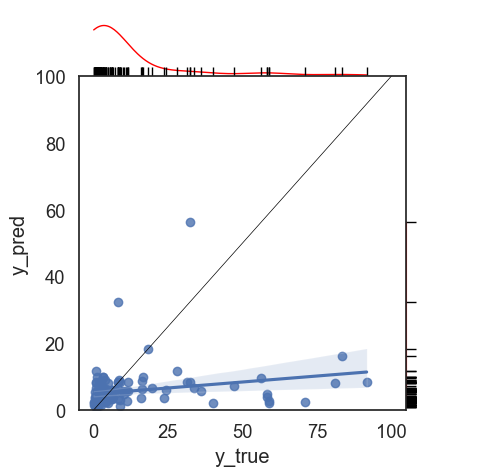

In [147]:
sns.set(style='white', font_scale=1.2)
g = sns.JointGrid(
    x=residuals["y_true"], y=residuals["y_pred"], 
    height=5, space=0, #marginal_kws=dict(fill=False, color="black" )
) #aspect=1.5            # Initiate multi-plot
g.plot_joint(sns.regplot) 

g.plot_marginals(
    sns.distplot, color='black', #kind="kde",
    kde=True, hist=False, #rug=True, 
    kde_kws={'color': 'red', 'cut': 0.0, 'lw': 1},
)


g.plot_marginals(sns.rugplot, color="black", height=.14, clip_on=True,
                    lw=1, #alpha=.005
)
              
x0, x1 = (0,100) 
y0, y1 = (0, 100)
lims = [min(x0, y0), max(x1, y1)]
g.ax_joint.plot(lims, lims, c= 'black', lw=.5,) # equal line
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

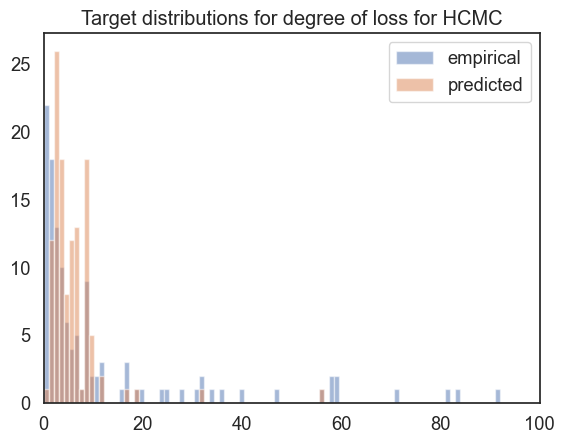

In [148]:
bins = np.linspace(0, 100, 100)

plt.hist(residuals["y_true"], bins, alpha=0.5, label='empirical')
plt.hist(residuals["y_pred"], bins, alpha=0.5, label='predicted')
plt.legend(loc='upper right')
plt.title("Target distributions for degree of loss for HCMC")
plt.xlim(0,100)
plt.show()


#### Inference

In [12]:
#-----------------------------------------------------------------------------
# Function 5 - inference - making inference with the BN model
#-----------------------------------------------------------------------------

condition=[1] #, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target (predict)
values = df_hcmc_bn.iloc[:,condition].to_numpy() # data for conditionalization

F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the
                                # nodes of the NPBN
              R,                # the rank correlation matrix 
              df_hcmc_bn, # DataFrame with df_hcmc
             # Output='mean')    # type of output data
              Output='median')    # type of output data

print("Inference - Uncertainty distribution: ", pd.Series(F.squeeze()).describe())

## predict target
y_pred = F.squeeze()

# Fill out the column(s) which are predicted
y_true=df_hcmc_bn.iloc[:,0].to_numpy()

# Calculate coefficient of determination
A = (y_pred - y_pred.mean(axis=0))/y_pred.std(axis=0)
B = (y_true - y_true.mean(axis=0))/y_true.std(axis=0)
correlation = (np.dot(B, A.T)/B.shape[0])
R2=correlation**2

# Calculate evaluation metrics
MAE = np.mean(np.abs(y_pred-y_true))
MBE = np.mean(y_pred-y_true)
RMSE = (np.mean((y_pred-y_true)**2))**(1/2)

print("MAE,:", MAE)  
print("MAE, MBE, RMSE, R2:", MAE, MBE, RMSE, R2)  


Making inference. Progress:  0%
Making inference. Progress:  0%
Making inference. Progress:  0%
Making inference. Progress:  0%
Making inference. Progress:  1%
Making inference. Progress:  1%
Making inference. Progress:  1%
Making inference. Progress:  2%
Making inference. Progress:  2%
Making inference. Progress:  2%
Making inference. Progress:  3%
Making inference. Progress:  3%
Making inference. Progress:  3%
Making inference. Progress:  4%
Making inference. Progress:  4%
Making inference. Progress:  4%
Making inference. Progress:  5%
Making inference. Progress:  5%
Making inference. Progress:  5%
Making inference. Progress:  6%
Making inference. Progress:  6%
Making inference. Progress:  6%
Making inference. Progress:  7%
Making inference. Progress:  7%
Making inference. Progress:  7%
Making inference. Progress:  8%
Making inference. Progress:  8%
Making inference. Progress:  8%
Making inference. Progress:  8%
Making inference. Progress:  9%
Making inference. Progress:  9%
Making i

In [13]:
y_pred_org = pd.concat([pd.Series(y_true), pd.Series(y_pred.astype(int))], axis=1)
y_pred_org.columns = ["y_true", "y_pred"]
print(y_pred_org.describe())


           y_true      y_pred
count  312.000000  312.000000
mean     4.545528    0.051282
std     13.067528    0.248335
min      0.000000    0.000000
25%      0.000000    0.000000
50%      0.000000    0.000000
75%      2.179167    0.000000
max     91.672324    2.000000


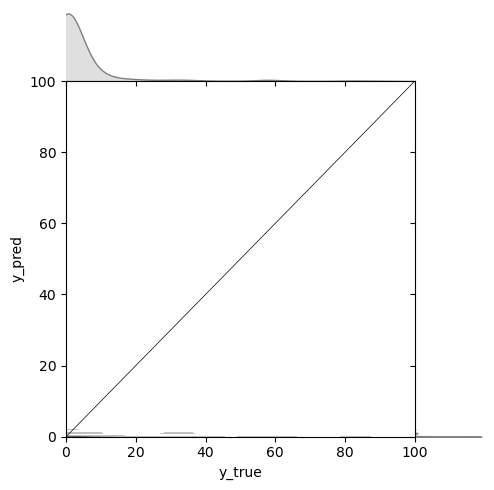

In [14]:
# Show the joint distribution using kernel density estimation
g = sns.jointplot(x=y_pred_org["y_true"], y=y_pred_org["y_pred"],
                  kind="kde", color='grey',
                  fill="true", height=5, space=0, levels=7)

x0, x1 = (0,100) 
y0, y1 = (0, 100)
lims = [min(x0, y0), max(x1, y1)]
g.ax_joint.plot(lims, lims, c= 'black', lw=.5,) # equal line
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

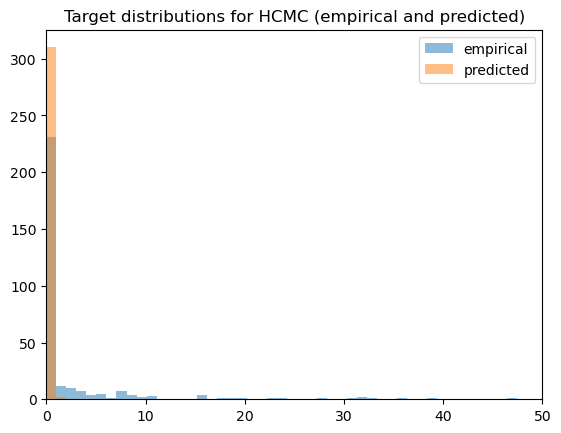

In [16]:
bins = np.linspace(0, 100, 100)

plt.hist((pd.Series(y_true.astype(int))), bins, alpha=0.5, label='empirical')
plt.hist((pd.Series(y_pred.astype(int))), bins, alpha=0.5, label='predicted')
plt.legend(loc='upper right')
plt.title("Target distributions for HCMC (empirical and predicted)")
plt.xlim(0,50)
plt.show()


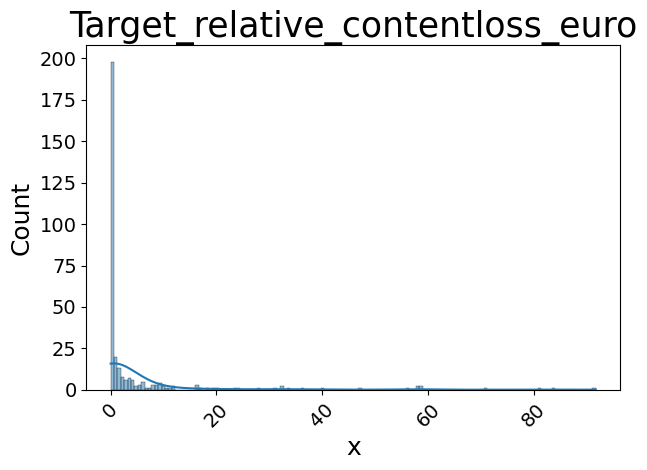

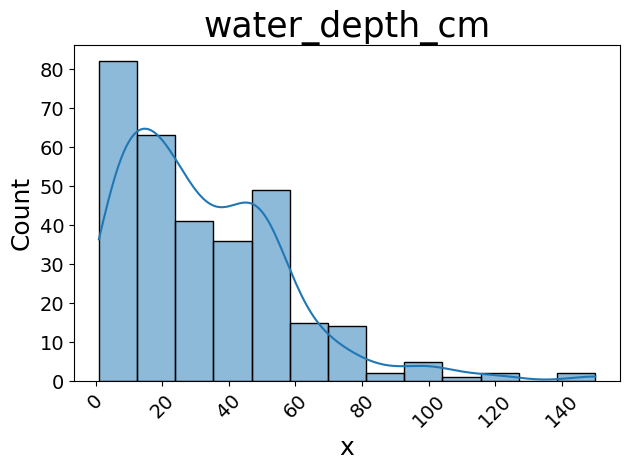

'BN plot saved in : c:\\Users\\Anna\\Documents\\UNI\\MA_topic\\flood-loss-models-4-HCMC\\bayesian_networks\\BN_visualize_bn_Target_contentloss_euro_margins.pdf'

In [18]:
#-----------------------------------------------------------------------------
# Function 2 - bn_visualize - Plot of the Bayesian Network
#-----------------------------------------------------------------------------

bn_visualize(parent_cell,           # structure of the BN
             R,                     # the rank correlation matrix (function 1)
             df_hcmc_bn.columns,          # names of variables
             fig_name = fig_name)   # figure name
# The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# rank correlations indicated on the arcs.

bn_visualize(parent_cell,                       # structure of the BN
             R,                                 # the rank correlation matrix 
             df_hcmc_bn.columns,                      # names of variables
             data = df_hcmc_bn,                       # DataFrame with data
             fig_name = fig_name + '_margins')  # figure name
# The plot presents the BN with 5 nodes and 7 arcs, with the (conditional)
# rank correlations indicated on the arcs. In this plot also the marginal
# distributions for each variable are incorporated.


In [19]:
#-----------------------------------------------------------------------------
# Function 3 - cvm_statistics - test goodness-of-fit of the Gaussian copula 
#-----------------------------------------------------------------------------

M = cvm_statistic(df_hcmc_bn,                   # df_predictorsFrame with df_hcmc
                  names = df_hcmc_bn.columns,   # names of variables
                  plot = True,               # create a plot (0=don't create plot)
                  fig_name = fig_name)    # figure name
                  
# The results of the goodness-of-fit test in terms of Cramer-von Mises
# statistic highlight that the Gaussian copula is in majority of cases the 
# most suitable for representing the dependency between variables, 
# especially for the variable of interest (safety). This is important as
# the method utilizes the Gaussian copula for dependence modelling.


## !! decalibration score = overall score if BN fullfills 

KeyboardInterrupt: 

In [20]:
M

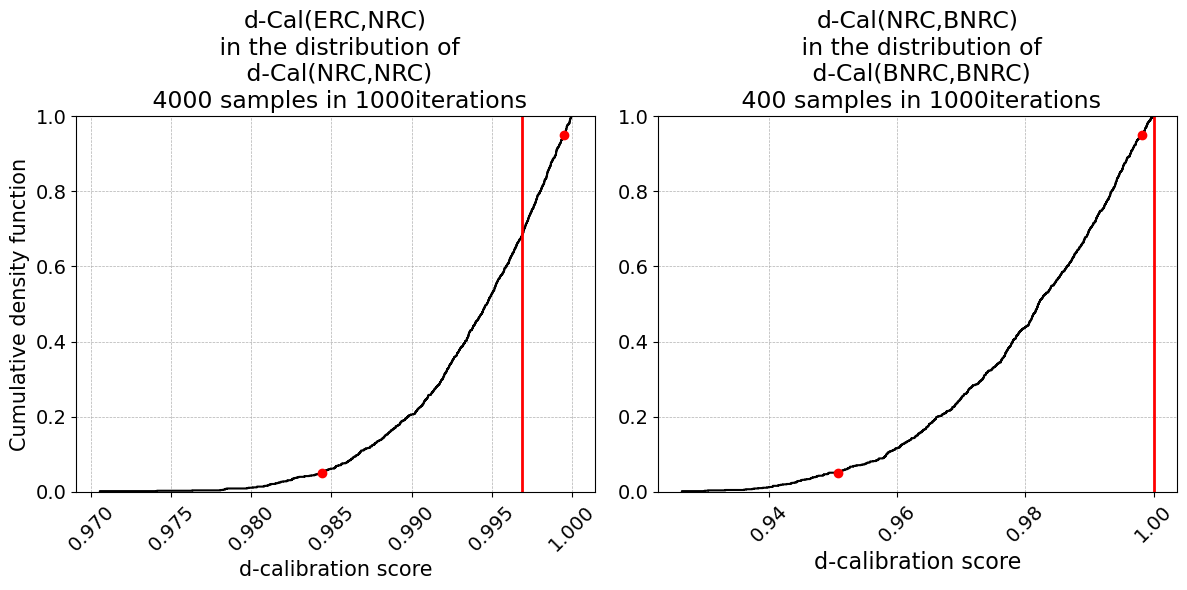

SUCCESS: The d-Cal of the empirical rank correlation matrix (ERC) fall between the confidence intervals of the d-Cal of the normal rank correlation matrix (NRC)

FAILURE: The d-Cal of the normal rank correlation matrix (NRC) is out of the confidence intervals of the d-Cal of the BN rank correlation matrix (BNRC)



In [21]:
#-----------------------------------------------------------------------------
# Function 4 - gaussian_distance - measuring d-calibration score
#-----------------------------------------------------------------------------

## TODO fix np.mul() --> fixed with np.mulitply() in d_cal.py from py_banshee package ~ 1h
## try to fix, otherwise write with CC Dominik (maybe mixed up respective matlab func()--> )

# gaussian_distance : validation: 
D_ERC,B_ERC,D_BNRC,B_BNRC = gaussian_distance(
                            R,        # the rank correlation matrix 
                            df_hcmc_bn,     # df_predictorsFrame with df_hcmc
                            4000,     # number of samples drawn d-Cal(ERC,NRC)
                            400,      # number of samples drawn d-Cal(NRC,BNRC)
                            1000,     # number of iterations to compute CI
                            Plot=True,          # create a plot (0=don't create plot)
                            Type='H',           # take Hellinger distance (default)
                            fig_name=fig_name)  # figure name

                        
# draw 4000 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (ERC,NRC)
# draw 400 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (NRC,BNRC)


# The d-calibration score of the empirical rank correlation matrix is
# inside the 90# confidence interval of the determinant of the empirical
# The d-calibration score of the BN's rank correlation matrix is well within  
# the 90# confidence interval of the determinant of the random normal distribution 
# sampled for the same correlation matrix. This supports the assumptions of
# a joint normal copula used in the BN model. It should be noted that the 
# test is sensitive to the number of samples drawn as well as the number of 
# iterations and is rather severe for large df_predictorssets.


In [18]:
df_hcmc.head(2)#.shape

,Target_businessreduction,flowvelocity,emergency_measures,water_depth_cm,bage,inundation_duration_h,shp_employees,flood_experience,resilienceLeftAlone,shp_content_value_euro,precautionary_measures_lowcost,b_area,resilience,precautionary_measures_expensive,hh_monthly_income_euro,shp_avgmonthly_sale_euro,contaminations
0,0,0.2,0.0,10.0,12.0,2.0,1,76,2.0,441.9,0.0,25.0,5.0,0.0,110.5,276.2,0
1,0,0.2,0.0,15.0,0.0,2.0,1,76,1.0,441.9,0.0,21.0,5.0,0.0,294.6,276.2,1


## Model transferability
Test trained NPBN for CanTHo DS

In [23]:
infile_name = "input_data_contentloss_cantho"
df_cantho = pd.read_excel(f"../input_survey_data/{infile_name}.xlsx")

## prepare CanTHo for BN - adpat with same column structure as training dataset
df_cantho = df_cantho[df_hcmc_bn.columns]

print(df_cantho.shape)
df_cantho.tail(2)

(317, 2)


,Target_relative_contentloss_euro,water_depth_cm
315,0.017669,20
316,0.000000,50


### predict on CanTho Bred

In [177]:
condition=[1, 2, 3, 4, 5, 6, 7] #, 4, 5, 6, 7, 8, 9, 10] #conditionalized variables, all except for target (predict)
values = df_cantho.iloc[:,condition].to_numpy() # data for conditionalization

F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the
                                # nodes of the NPBN
              R,                # the rank correlation matrix 
              df_cantho,        # DataFrame with df_hcmc
              #Output='mean')    # type of output data
              Output='median')    # type of output data

print("Inference - Uncertainty distribution: ", pd.Series(F.squeeze()).describe())

## predict target
y_pred = F.squeeze()

# Fill out the column(s) which are predicted
y_true=df_cantho.iloc[:,0].to_numpy()

# Calculate coefficient of determination
A = (y_pred - y_pred.mean(axis=0))/y_pred.std(axis=0)
B = (y_true - y_true.mean(axis=0))/y_true.std(axis=0)
correlation = (np.dot(B, A.T)/B.shape[0])
R2=correlation**2

# Calculate evaluation metrics
MAE = np.mean(np.abs(y_pred-y_true))
MBE = np.mean(y_pred-y_true)
RMSE = (np.mean((y_pred-y_true)**2))**(1/2)

print("MAE,:", MAE)  
print("MAE, MBE, RMSE, R2:", MAE, MBE, RMSE, R2)  


Making inference. Progress:  0%
Making inference. Progress:  0%
Making inference. Progress:  0%
Making inference. Progress:  0%
Making inference. Progress:  1%
Making inference. Progress:  1%
Making inference. Progress:  1%
Making inference. Progress:  2%
Making inference. Progress:  2%
Making inference. Progress:  2%
Making inference. Progress:  3%
Making inference. Progress:  3%
Making inference. Progress:  3%
Making inference. Progress:  4%
Making inference. Progress:  4%
Making inference. Progress:  4%
Making inference. Progress:  5%
Making inference. Progress:  5%
Making inference. Progress:  5%
Making inference. Progress:  5%
Making inference. Progress:  6%
Making inference. Progress:  6%
Making inference. Progress:  6%
Making inference. Progress:  7%
Making inference. Progress:  7%
Making inference. Progress:  7%
Making inference. Progress:  8%
Making inference. Progress:  8%
Making inference. Progress:  8%
Making inference. Progress:  9%
Making inference. Progress:  9%
Making i

In [180]:
y_pred_org = pd.concat([pd.Series(y_true), pd.Series(y_pred.astype(int))], axis=1)
y_pred_org.columns = ["y_true", "y_pred"]
y_pred_org.describe()



,y_true,y_pred
count,317.000000,317.000000
mean,40.473186,40.217666
std,21.537355,10.727933
min,0.000000,15.000000
25%,25.000000,30.000000
50%,40.000000,40.000000
75%,50.000000,50.000000
max,100.000000,100.000000


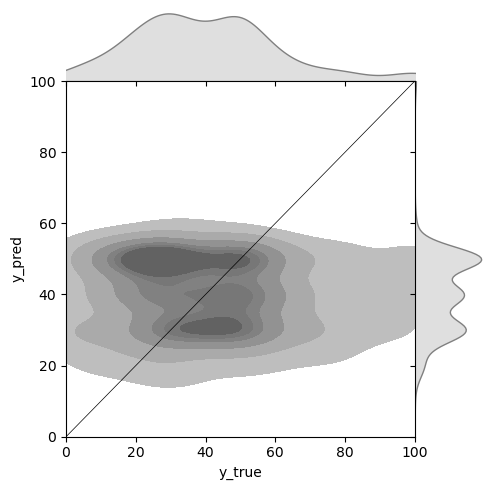

In [181]:
g = sns.jointplot(x=y_pred_org["y_true"], y=y_pred_org["y_pred"],
                  kind="kde", color='grey',
                  fill="true", height=5, space=0, levels=7)

x0, x1 = (0,100) 
y0, y1 = (0, 100)
lims = [min(x0, y0), max(x1, y1)]
g.ax_joint.plot(lims, lims, c= 'black', lw=.5,) # equal line
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

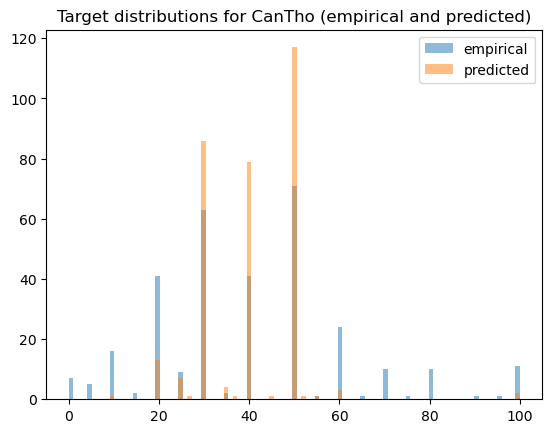

In [66]:
bins = np.linspace(0, 100, 100)

plt.hist((pd.Series(y_true.astype(int))), bins, alpha=0.5, label='empirical')
plt.hist((pd.Series(y_pred.astype(int))), bins, alpha=0.5, label='predicted')
plt.legend(loc='upper right')
plt.title("Target distributions for CanTho (empirical and predicted)")
plt.show()


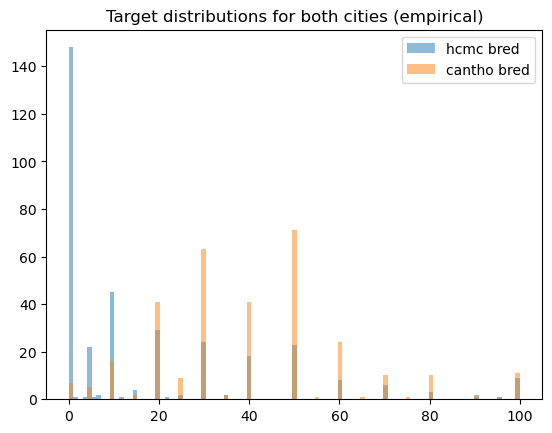

In [182]:
bins = np.linspace(0, 100, 100)
plt.hist(df_hcmc_bn["Target_businessreduction"], bins, alpha=0.5, label='hcmc bred')
plt.hist(df_cantho["Target_businessreduction"], bins, alpha=0.5, label='cantho bred')
plt.legend(loc='upper right')
plt.title("Target distributions for both cities (empirical)")
plt.show()


### Cross validate performance 

In [ ]:
# from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold, cross_validate, cross_val_predict


# cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=seed)

# scores = cross_validate(   # allows specifying multiple metrics for evaluation comparated to cross_val_score
#     F, 
#     df_hcmc.iloc[:,condition], y_true, 
#     # return_train_score=  # if True: more computanitonal expensive, gives scores of training sets
#     scoring="neg_MAE",# "neg_mean_absolute_error",,  # Strategy to evaluate the performance of the cross-validated model on the test set.
#     cv=cv, 
#     n_jobs=-1
# ) 